In [7]:
import pandas as pd
import os
import numpy as np
from PIL import  Image
import matplotlib.pyplot as plt

folder_path = '/Users/pmzff/Documents/GitHub/ModularCircFF/Emulation'


# Report on Uncertainty Quantification and Calibration of the Cardiac Model ModularCirc

## Introduction

This report details the work conducted for WP3, the uncertainty quantification and calibration of cardiac models. The primary model used for this study was the 0D model Korakianitis and Shi (Figure 1), from which we simulated right heart pressure traces and cardiac output. We focused on calibrating five key model parameters while keeping the others fixed. These five parameters were selected via a gloal sensitivity analysis of the model and through expert advice from other members of the project. All simulations were performed using Max's `ModularCirc`. 

![Figure 1: Korakianitis and Shi Model](KorakianitisModel_circuit.png)

*Figure 1: Korakianitis and Shi Model.*


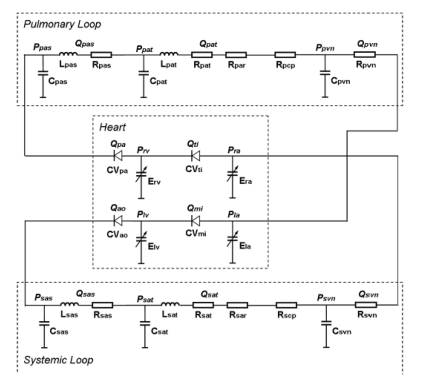

In [8]:
%matplotlib inline
img = np.asarray(Image.open(f'{os.getcwd()}/KorakianitisModel_circuit.png'))
show_ = plt.imshow(img)
plt.axis('off')
plt.show()

## Methodology

### Sampling and Simulation

Synthetic data was created using the 0D Korakianitis and Shi simulator.

- **Model Parameters:** 

 To simplify our methodology, only five of the model parameters were sampled namely $R_{pat}, C_{pat}, C_{svn}$, the right-ventricle activation function, $rv.E_{act}$, and duration of pulse, $T$. All other parameters were fixed to the point estimates given in the Korakianitis paper. The parameters were sampled 100 times using the Sobol method. The point estimate of each sampled parameter along with their range given by their scaling facotrs are given in Table 1. 

| Parameter    | Point Estimate| Scaling Factor (Min) | Scaling Factor (Max) |
|:-------------|:------:|:-------:|:-------:|
| $R_{pat}$    | 0.31   | 0.5     | 1.5     |
| $C_{pat}$    | 3.8    | 0.5     | 1.5     |
| $C_{svn}$    | 20.5   | 0.5     | 1.5     |   
| $rv.E{act}$  | 1.15   | 0.5     | 3       |
| $T$          | 1      | 0.4     | 0.96    |

*Table 1: Point estimates of parameters with sampling range given by the minimum and maximum scaling factor value.* 


- **Simulation Model:** 

We used ModularCirc to run simulations of Korakianitis and Shi's model formulation of the cardiac loop. From this we recorded pressure transients in the right arterial tree and cardiac output. Figure 2 shows a plot of the 100 simulated pressure transients. 

![Figure 2: Pressure Traces](pressure_traces.png)

*Figure 2: Plot of 100 Simulated Pressure Transients in the Arterial Tree.*





### Principal Component Analysis (PCA)

- **PCA of Pressure Trace:** 

A principle component analysis was conducted on the pressure traces. Figure 3 shows histograms of the frist 10 principle compoments of the pressure traces. Figure 4 shows the variance explained and cumulative variance of the principle components. We found that over $99%$ of the variance could be explained using the first three principle components.


![Figure 3: PCA Pressure Traces](PCA_histogram.png)

*Figure 3: Histograms of the first 10 principle components of the pressure traces.*

![Figure 4: PCA Pressure Traces](PCA_variance_explained.png)

*Figure 4: Left: Variance explained by each principle components of the pressure trace. Right: Cumulative sum of variance explained by each principle component of the pressure trace.*

- **Principal Components Recorded:** 

As over $99%$ of the variance could be explained using the first three principle components, we chose to build an emulator for these rather than the whole pressure trace. 


## Emulator Development

We developed emulators for outputs of the model that we believe are observable in patients and of interest in light of pulmonary arterial hypertension. We developed a single emulator for each of the first three principle components (PC1, PC2 and PC3), cardiac output (CO) and summary statistics of the pressure traces namely the maximum, minimum and mean pressure. We intially developed Gaussian process emulators for each output. 

### Gaussian Process Emulators

Each emulator used a radial basis function kernel and zero mean function.  We trained the emulator on $80\%$ of the simulated data and reserved the other $20\%$ for testing the emulator's predictive power. 

**GP Emulator Predicitve Power, $R^2$**

In each case, $R^2$ was calculated for the error between the simulated output (e.g. PC1) and the predicted value. For all emulators, the $R^2$ between the simulated and predicted values is $>0.98$. The trained emulators and their respective $R^2$ are gieven below. 



In [4]:
GP_emulator_results = pd.read_pickle(f'{folder_path}/Outputs/Emulators/RBF_models_and_r2_scores.csv')
GP_emulator_results

,R2_Score,Model
y_PC1,0.998637,\nName : GP regression\nObjective : 82.9228281...
all_y_PC1,0.998650,\nName : GP regression\nObjective : 82.6900306...
CO_y_PC1,0.998637,\nName : GP regression\nObjective : 82.9228280...
y_PC2,0.997759,\nName : GP regression\nObjective : -8.5241813...
all_y_PC2,0.997584,\nName : GP regression\nObjective : -9.3995655...
CO_y_PC2,0.997759,\nName : GP regression\nObjective : -8.5241813...
y_PC3,0.984687,\nName : GP regression\nObjective : -19.126323...
all_y_PC3,0.991417,\nName : GP regression\nObjective : -30.904616...
CO_y_PC3,0.984686,\nName : GP regression\nObjective : -19.126323...
CO,0.986648,\nName : GP regression\nObjective : -126.19235...



### Linear Regression Models

As the $R^2$ for the Gaussian process emulators was close to 1 in all cases, it seems natural to investigate whether a linear regression emulator would fit just as well and thus save considerable computing power. We fit a seperate linear regression model to each of the outputs PC1, PC2, PC3, CO, maximum pressure, minimum pressure, and mean pressure.

**Linear Emulator Predicitve Power, $R^2$**

Again, in each case $R^2$ was calculated for the error between the simulated output (e.g. PC1) and the predicted value. All linear regression models fitted well to the data and had relatively good $R^2$ values ($>0.8$). However, the emulator for PC3 did not perform as well and had a $R^2$ value of 0.65 (to 2d.p.). The trained emulators and their respective $R^2$ are gieven below. 


In [5]:
linear_emulator_results = pd.read_pickle(f'{folder_path}/Outputs/Emulators/linear_models_and_r2_scores.csv')
linear_emulator_results

,R2_Score,Model
y_PC1,0.987922,LinearRegression()
all_y_PC1,0.987971,LinearRegression()
CO_y_PC1,0.987922,LinearRegression()
y_PC2,0.882277,LinearRegression()
all_y_PC2,0.888562,LinearRegression()
CO_y_PC2,0.882277,LinearRegression()
y_PC3,0.647736,LinearRegression()
all_y_PC3,0.873160,LinearRegression()
CO_y_PC3,0.647736,LinearRegression()
CO,0.940900,LinearRegression()



## Calibration of Linear Regession Model

As these models are linear, calibration is straightforward and just requires computing the inverse problem via linear algebra. In mathematical notation, we have $$y = \beta X + c + \epsilon$$ where $y$ is our output (e.g. PC1, maximum pressure etc), X is the matrix of sampled input parameters and $\beta$ is the vector of model coefficients. 

Then, for any given observation $y_{obs}$, the inverse problem just requires computing $$x^*=(y_{obs}-\beta_0)(\beta^T \beta)^{-1} \beta^T$$
where $\beta_0$ is the intercept of the linear model. 

Firstly we calibrate each model individually, computing a mean squared error statistic to assess performance. Then we extend our methodolgy to calibrate all models simultaneously.

### Single Output Calibration 

As discussed, we first calibrate each model individually. It is worth noting here that since we have five input parameters to calibrate and one observation, $y_{obs}$, we can only find the minimum norm solution which is unlikely to be close to the actual values of the input parameters which led to the observation. Thus once calibrated we feed the estimated input parameters back into the linear model to assess whetehr we can recover the observation value. In theory we only need to calibrate each model using a single observation, however, for brevity I calibrate using a range of 20 observations and calculate MSE on the difference between the $y^*$ predicted using the calibrated inputs and the true value of the observation $y_{obs}$. 

- **MSE of $y_{obs}$ and $y$ for all linear models:** 
Below is a table of the MSE between the output of the calibrated model  and the (true) simulated output for 20 simulations.

In [9]:
linear_calibration_results = pd.read_csv(f'/Users/pmzff/Documents/GitHub/ModularCircFF/LinearCalibration/linear_model_calibration_mse_results.csv')
calibrated_max_press = pd.read_csv(f'/Users/pmzff/Documents/GitHub/ModularCircFF/LinearCalibration/calibrated_max_press.csv')

linear_calibration_results


,Unnamed: 0,MSE
0,model_y_PC1,6.557406e-30
1,model_all_y_PC1,3.540260e-29
2,model_CO_y_PC1,6.557406e-30
3,model_y_PC2,1.117425e-31
4,model_all_y_PC2,5.669938e-32
5,model_CO_y_PC2,1.117425e-31
6,model_y_PC3,8.017652e-31
7,model_all_y_PC3,1.369875e-30
8,model_CO_y_PC3,8.017652e-31
9,model_CO,1.873545e-31


- **Recovered Estimates:** 
As an example here are the values of the 20 simulated outputs and their respective values from calibrated model of maximum pressure.

In [12]:
calibrated_max_press

,y_true,y_calibrated
0,22.551249,22.551249
1,15.931235,15.931235
2,28.465645,28.465645
3,24.604022,24.604022
4,22.291235,22.291235
5,17.320841,17.320841
6,26.449743,26.449743
7,28.691640,28.691640
8,31.187409,31.187409
9,31.023888,31.023888



### Multiple Output Calibration (PC1, PC2, PC3, Cardiac Output, Max Pressure)

The next step is to calibrate multiple models simulataneously. Here we hope that we are able to recover a better approxiamtion to the true solution of the inverse problem. In mathematical notation, we are solving the following. $$y = \beta X + c + \epsilon$$ where $y$ is the column vector of multiple outputs, $X$ is the matrix of input parameters and $\beta$ is the matrix of model coefficients. More specifically, $$y = \begin{bmatrix}
PC1 \\
PC2 \\
PC3 \\
CO  \\
max(press) 
\end{bmatrix} $$

$$ X = \begin{bmatrix}
R_{pat} \\
C_{pat} \\
C_{svn} \\
T \\
RV.E_{act} 
\end{bmatrix}
 * \begin{bmatrix}
\beta_1\\
\beta_2\\
\beta_3\\
\beta_4\\
\beta_5
\end{bmatrix}$$


## Discussion

- **Comparison of Emulators:** [Insert discussion on the performance of Gaussian process emulators vs. linear regression models]
- **Calibration Accuracy:** [Insert discussion on the accuracy of the calibration process for both single and multiple outputs]
- **Future Work:** [Insert potential future directions and improvements]

## Conclusion

Summarise the key findings and their implications for the calibration of cardiac models.

---

Additional details and results